In [77]:
%load_ext autoreload
%autoreload 2


import os
import sys
import glob
import torch
import json
import pandas as pd
import time
import qgrid
import torch


from pytorch_utils.logging import LoggerReader
from pytorch_utils.collection_utils import keychain_value_iter
from collections import defaultdict, OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
# import mpld3
# mpld3.enable_notebook()
%matplotlib inline

from nb_common import load_results


DEVICE = 'cuda:2'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# root = Path('/scratch2/chofer/toporeg_sandbox/'

# root = Path('/tmp/tmp_results')
# root = Path('/tmp/testing')
root = Path('/tmp/debug')
#root = Path('/tmp/grid_1')


# root = Path('/home/pma/chofer/repositories/toporeg_sandbox/results_energy/')


In [79]:
args_white_list = {
    'num_runs', 
    'num_samples', 
    'num_batches',
    'num_sub_batches',
    'batch_size',
    'size_sub_batch',
    'tag', 
    'eval_interval',
    'model', 
    'lr_init',
    'weight_decay',
    'ds_train',
    'ds_test' ,
    'momentum',
    'augment',
    'losses',
    'w_losses',
}

# tag='spectral_norm'
tag = None


def progress(logger_reader):
    n_runs = len(logger_reader)
    
    if len(logger_reader) == 0 or 'batch_i' not in logger_reader[-1]:
        return "not started"    
    
    n_batches = logger_reader[-1]["batch_i"]+1        
        
    args = logger_reader.experiment_args
    
    if n_runs == args['num_runs'] and n_batches == args['num_batches']:
        return True
    else:
        s = '{}/{}'.format(n_runs, str(args['num_runs']))
        s += ' {:.2%} '.format(n_batches/float(args['num_batches']))
        return s
    

def args_df_from_results():
    RESULTS = load_results(root, tag=tag)
    R = []
    
    for i, r in enumerate(RESULTS):
        
        df = {k: str(v) if isinstance(v, (list, tuple)) else v for  k, v in r.experiment_args.items() if k in args_white_list}
        df['experiment'] = r.experiment_args['experiment_type']
        df['date'] = r.date
        df = pd.DataFrame(df, index=[i]) 
        df['progress'] = progress(r)
        
        R.append(df)   
        
    return pd.concat(R, sort=False)


def progress_from_results():
    RESULTS = load_results(root, tag=tag)
    
    tmp = defaultdict(list)
    
    for i, r in enumerate(RESULTS):
        
        p = progress(r)
        
        if isinstance(p, str):
            tmp['Idx'].append(i)
            tmp['progress'].append(p)
            tmp['path'].append(r.path)
            
    return pd.DataFrame(tmp)
    

def df_from_results():
    RESULTS = load_results(root, tag=tag)
    A = args_df_from_results()
    
    tmp = []
    for i, r in enumerate(RESULTS):
        df = {}
        for k in [
            'linear_train',
            'linear_test',
            'retrained_linear_train',
            'retrained_linear_test',
            'explicit_linear_train', 
            'explicit_linear_test'        
        ]:
            try:
                df[k] = np.mean([run[k][-1] for run in r])
                
            except KeyError:
                pass
            
        tmp.append(pd.DataFrame(df, index=[i]))
    
    B = pd.concat(tmp, sort=False)
    return A.join(B) 

In [80]:
def plt_losses(idx,from_batch_i=0):
    RESULTS = load_results(root)
    plt.figure() 
    
    r = RESULTS[idx][0] 
    
    for k, v in r.items():
        
        if 'batch_' in k and k not in ['batch_cls_loss', 'batch_i']:
            Y = r[k][from_batch_i:]
            X = list(range(len(Y)))
            plt.plot(X, Y, label=k.split('batch_')[1], alpha=0.5)
            
    plt.legend()
    plt.grid()
    
def plt_curves(idx, keys):
    if isinstance(keys, str):
        keys = [keys]
    RESULTS = load_results(root)
    plt.figure() 
    
    r = RESULTS[idx][0] 
    
    for k in keys:
        plt.plot(r[k], label=k)
    plt.legend()
    plt.grid()
    
def plt_loss_from_multiple_exp(idxs, loss_name, from_batch_i=0, labeler=None, run_i=0):
    RESULTS = load_results(root)
    plt.figure() 
    
    for idx in idxs:
        
        r = RESULTS[idx]
        label = 'Idx_{}'.format(idx) if labeler is None else str(labeler(r))
        plt.plot(r[run_i][loss_name][from_batch_i:], label=label)

    plt.legend()
    plt.grid()

In [81]:
progress_from_results()

""


In [82]:
args_df_from_results()

,num_batches,tag,eval_interval,num_runs,num_samples,model,lr_init,weight_decay,ds_train,ds_test,momentum,augment,batch_size,losses,w_losses,experiment,date,progress
0,30000,need_for_performance,30000,1,None,"['ResNet18', {'compactification_cfg': ['sphere...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,256,"[['CrossEntropy', {'reduction': 'mean'}]]",None,core.experiment.Experiment,2020-12-09 08:37:33,True
1,30000,need_for_performance,30000,1,None,"['ResNet18', {'compactification_cfg': ['none',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,256,"[['CrossEntropy', {'reduction': 'mean'}]]",None,core.experiment.Experiment,2020-12-09 08:38:52,True


In [83]:
qgrid_widget = qgrid.show_grid(df_from_results(), show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

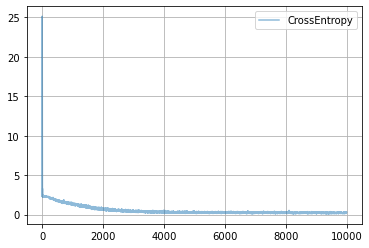

In [68]:
plt_losses(-1, from_batch_i=0)
# plt.gca().set_ylim((0, 3))
# plt.gca().plot([0, 40000],[np.log(10), np.log(10)])

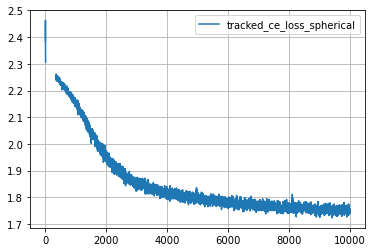

In [69]:
plt_curves(-1, [
#     'r_linear', 
    'tracked_ce_loss_spherical', 
#     'batch_CrossEntropy'
])

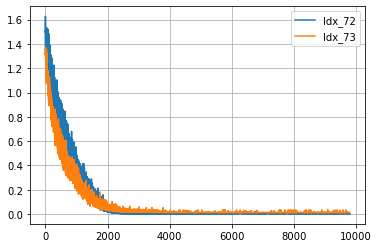

In [58]:
plt_loss_from_multiple_exp([72, 73], 'batch_CrossEntropy', from_batch_i=200)

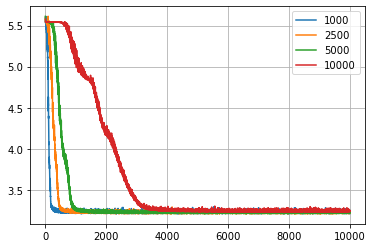

In [48]:
plt_loss_from_multiple_exp([7, 8, 9, 10], 'batch_SupConLoss', labeler=lambda x: x.experiment_args['num_samples'], from_batch_i=0)

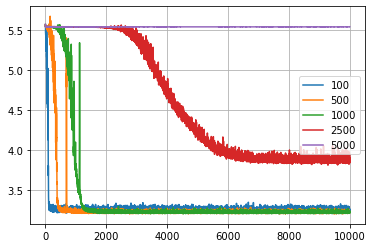

In [55]:
plt_loss_from_multiple_exp([11, 12, 13, 14, 15], 'batch_SupConLoss', labeler=lambda x: x.experiment_args['num_samples'], from_batch_i=0)

In [382]:
load_results(root)[-3].experiment_args

{'num_runs': 1,
 'output_root_dir': '/tmp/testing/',
 'num_batches': 50000,
 'augment': 'none',
 'tag': '',
 'model': ['SimpleCNN13',
  {'batch_norm': True,
   'drop_out': False,
   'final_bn': True,
   'compactification': 'sphere_l2',
   'linear_bias': False,
   'cls_norm': 'none',
   'latent_dim': None}],
 'batch_cfg': [256, {'+': 1, '-': 0}],
 'lr_init': 0.1,
 'momentum': 0.0,
 'weight_decay': 0.001,
 'ds_train': 'cifar10_train',
 'ds_test': 'cifar10_test',
 'energies': [['CrossEntropy', {}]],
 'energies_track_only': [['SupConLossWeighted',
   {'temperature': 0.1, 'weight': 1.0}]],
 'w_energies': None,
 'eval_interval': 50000,
 'evaluation_policies': ['optimized_linear', 'explicit_linear'],
 'experiment_type': 'core.experiment_energy.ExpEnergyRandomLabeledData'}

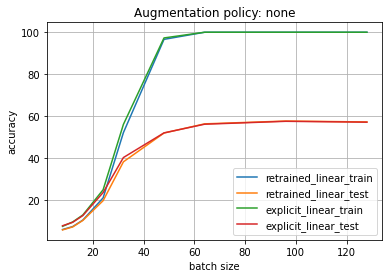

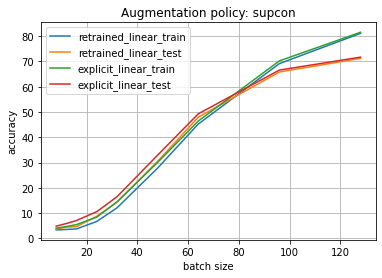

In [227]:
def plt_batch_size_degeneration():
    R = load_results(root)
    R = [r for r in R if r.experiment_args['tag'] == 'small_batches_degeneration']
    
    eval_policies = ['retrained_linear_train', 'retrained_linear_test', 'explicit_linear_train', 'explicit_linear_test']
    
    for aug_policy in ['none', 'supcon']:
        
        RR = [r for r in R if r.experiment_args['augment'] == aug_policy]
        RR = sorted(RR, key=lambda x: x.experiment_args['batch_size'])
        
        plt.figure()
        plt.title('Augmentation policy: ' + aug_policy)
        
        X = [r.experiment_args['batch_size'] for r in RR]
        
        for eval_p in eval_policies:
            Y = [r[0][eval_p][-1] for r in RR]
            
            plt.plot(X, Y, label=eval_p)
        
        plt.legend()
        plt.xlabel('batch size')
        plt.ylabel('accuracy')
        plt.grid()
        
plt_batch_size_degeneration()

In [98]:
r = load_results(root)[-1]
print(r.experiment_args['losses'])
r[0]['retrained_linear_test']

[['CrossEntropy', {'reduction': 'mean'}]]


[35.39]

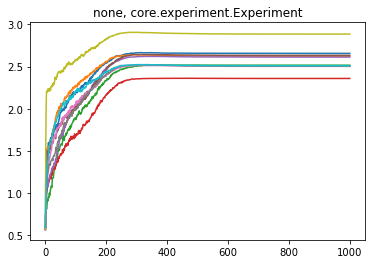

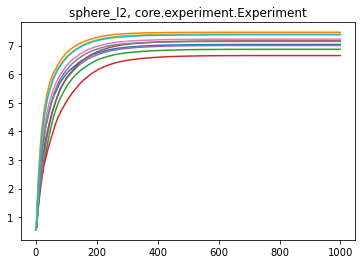

In [54]:
def plt_norms():
    R = load_results(root, tag='norms_of_w')
#     R = load_results(root)[-1:]
    
    for r in R:
        
        title = ''
        
        title += r.experiment_args['model'][1]['compactification']
        title += ', '
        title += r.experiment_args['experiment_type']
        
        
        plt.figure()
        plt.title(title)
         
        X = np.array(r[0]['norm_w']).T
        
        for x in X: 
            plt.plot(x)
        
        
    
plt_norms()

4
{'output_root_dir': '/tmp/debug/', 'num_batches': 10000, 'tag': 'optimize_vanilla_ce_track_spherical_ce', 'eval_interval': 10000, 'num_runs': 1, 'num_samples': None, 'model': ['ResNet18', {'compactification': 'none', 'latent_dim': None, 'linear_bias': False, 'num_classes': 10}], 'lr_init': 0.1, 'weight_decay': 0.0001, 'ds_train': 'cifar10_train', 'ds_test': 'cifar10_test', 'momentum': 0.9, 'augment': 'none', 'batch_size': 256, 'losses': [['CrossEntropy', {'reduction': 'mean'}]], 'losses_track_only': [], 'w_losses': None, 'evaluation_policies': ['linear', 'retrained_linear', 'explicit_linear'], 'experiment_type': 'core.experiment.Experiment'}
{'output_root_dir': '/tmp/debug/', 'num_batches': 10000, 'tag': 'optimize_vanilla_ce_track_spherical_ce', 'eval_interval': 10000, 'num_runs': 1, 'num_samples': None, 'model': ['ResNet18', {'compactification': 'sphere_l2', 'latent_dim': None, 'linear_bias': False, 'norm_linear': False}], 'lr_init': 0.1, 'weight_decay': 0.0001, 'ds_train': 'cifar10

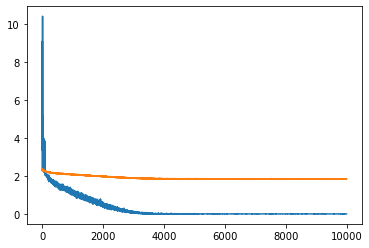

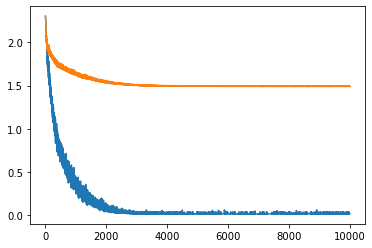

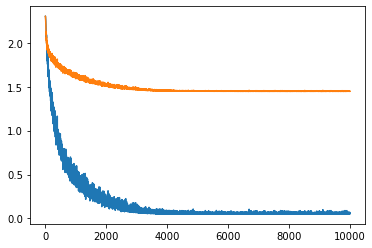

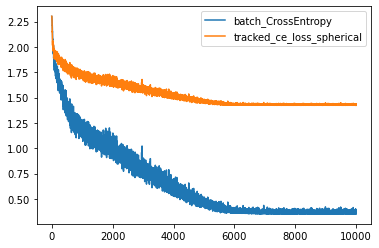

In [51]:
def plt_trained_vanilla_ce_tracked_spherical_ce():
    R = load_results(root, tag='optimize_vanilla_ce_track_spherical_ce')
    print(len(R))
    
    
    for r in R:
        print(r.experiment_args)
        plt.figure()
        for k in ['batch_CrossEntropy', 'tracked_ce_loss_spherical']:
            plt.plot(r[0][k], label=k)
    plt.legend()

plt_trained_vanilla_ce_tracked_spherical_ce()